In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from idlmam import set_seed

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, getMaskByFill

import os

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
data_url_zip = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

#Download this dataset if we have not already done so! 
if not os.path.isdir('./data/PetImages'):
    resp = urlopen(data_url_zip)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path = './data')

#This file is bad and will screw up the data loader! 
bad_files = [
    './data/PetImages/Dog/11702.jpg',
    "./data/PetImages/Cat/666.jpg"
]
for f in bad_files:
    if os.path.isfile(f):
        os.remove(f)


In [7]:
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning) #Don't bother us about these bad files, thank you.

In [8]:
all_images = torchvision.datasets.ImageFolder("./data/PetImages", transform=transforms.Compose(
    [
        transforms.Resize(130), #The smallest of width/height will become 130 pixels. 
        transforms.CenterCrop(128), # Take the center 128 x 128 image
        transforms.ToTensor(), #Convert to a PyTorch tensor
    ]))

train_size = int(len(all_images)*0.8) #Pick 80% for training 
test_size = len(all_images)-train_size #20% remainder for testing

train_data, test_data = torch.utils.data.random_split(all_images, (train_size, test_size)) #Create the random splits of the specified sizes

In [9]:
B = 128
train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

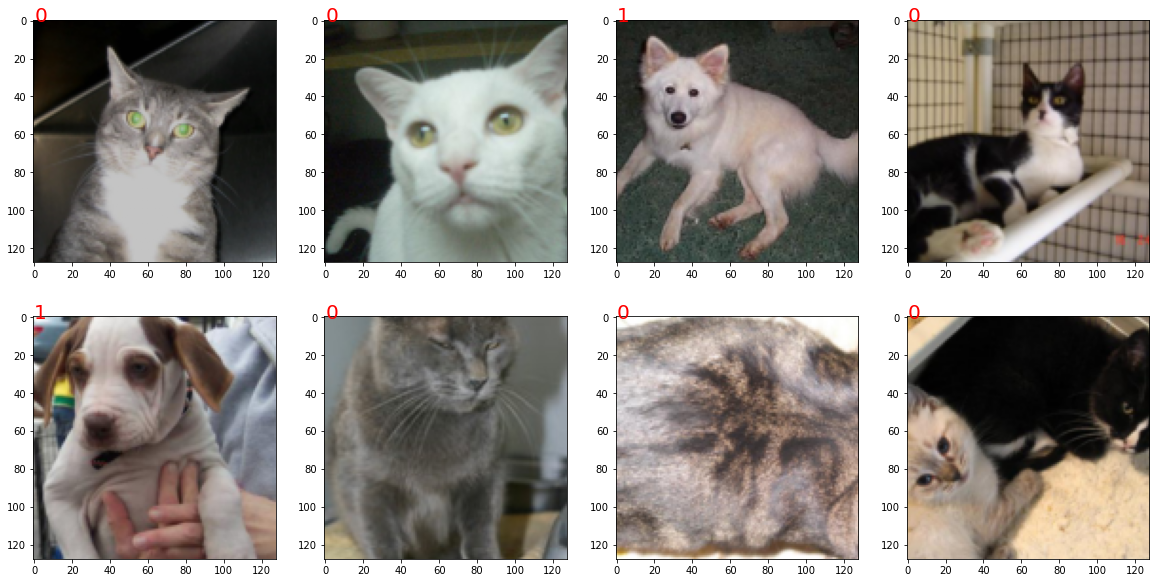

In [10]:
f, axarr = plt.subplots(2,4, figsize=(20,10)) #Create a grid of 8 images (2 x 4)
for i in range(2): # Rows
    for j in range(4): #Columns
        x, y = test_data[i*4+j] # Grab an image from the test corpus
        axarr[i,j].imshow(x.numpy().transpose(1,2,0)) #Plot the image 
        axarr[i,j].text(0.0, 0.5, str(round(y,2)), dict(size=20, color='red')) #Draw the label in the top left corner.

In [11]:
model = torchvision.models.resnet18()
#We are going to perfrom some "surgery"
model.fc = nn.Linear(model.fc.in_features, 2)

In [12]:
loss = nn.CrossEntropyLoss()
normal_results = train_network(model, loss, train_loader, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

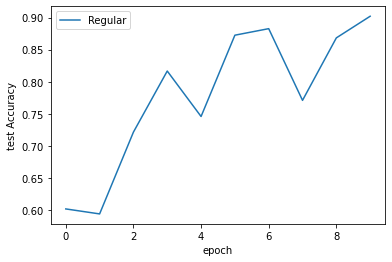

In [13]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')

In [14]:
model_pretrained = torchvision.models.resnet18(pretrained=True) # a model that has already been trained on some dataset
#We are going to perfrom some "surgery"
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 2)

In [15]:
filters_pretrained = model_pretrained.conv1.weight.data.cpu().numpy() #Grabbing the first convolutional filters weights, moving them to the CPU, and turning them into a numpy tensor

In [16]:
#Normalize so that the min=0, and max=1
filters_pretrained = filters_pretrained-np.min(filters_pretrained) #shift so everything is in the range [0, Max value]
filters_pretrained = filters_pretrained/np.max(filters_pretrained) #Re-scale so everything is [0, 1]

In [17]:
#The weights are shaped as (#Filters, C, W, H)
#matplotlib expects (W, H, C), so we will move the channel dimension 
filters_pretrained = np.moveaxis(filters_pretrained, 1, -1)

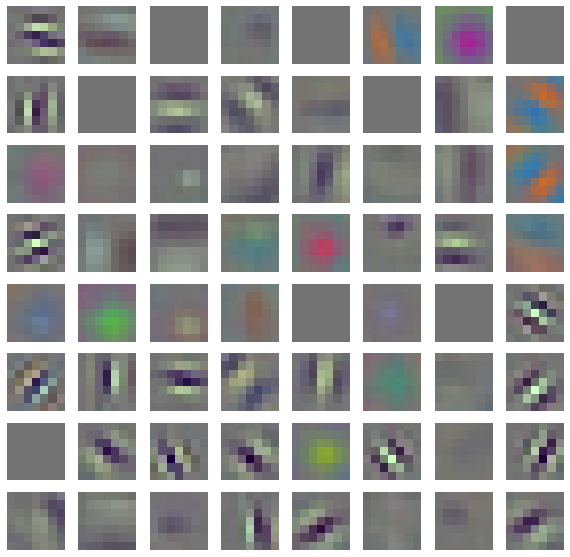

In [18]:
i_max = int(round(np.sqrt(filters_pretrained.shape[0]))) #take sqrt(# items) to make a square grid of images
j_max = int(np.floor(filters_pretrained.shape[0]/float(i_max))) #divide by # of rows
f, axarr = plt.subplots(i_max,j_max, figsize=(10,10)) # make the grid to plot the images in
for i in range(i_max): #each row
    for j in range(j_max): #each column
        indx = i*j_max+j #index into the filters
        axarr[i,j].imshow(filters_pretrained[indx,:]) #plot the specific filter
        axarr[i,j].set_axis_off() # turn off the numbered axis to avoid clutter

In [19]:
def visualizeFilters(conv_filters):
    #Normalize so that the min=0, and max=1
    conv_filters = conv_filters-np.min(conv_filters)
    conv_filters = conv_filters/np.max(conv_filters)
    #The weights are shaped as (#Filters, C, W, H)
    #matplotlib expects (W, H, C), so we will move the channel dimension 
    conv_filters = np.moveaxis(conv_filters, 1, -1)
    
    i_max = int(round(np.sqrt(conv_filters.shape[0])))
    j_max = int(np.floor(conv_filters.shape[0]/float(i_max)))
    f, axarr = plt.subplots(i_max,j_max, figsize=(10,10))
    for i in range(i_max):
        for j in range(j_max):
            indx = i*j_max+j
            axarr[i,j].imshow(conv_filters[indx,:])
            axarr[i,j].set_axis_off()

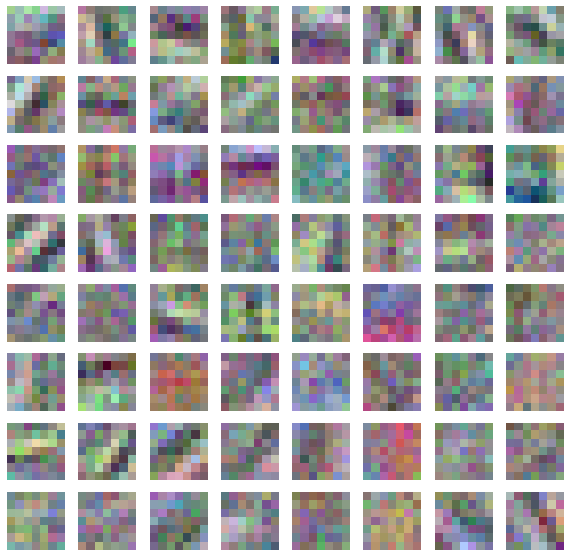

In [20]:
filters_catdog = model.conv1.weight.data.cpu().numpy() #filters from the model we trained at the start of this chapter
visualizeFilters(filters_catdog) #plot the results

In [21]:
class NormalizeInput(nn.Module):
    def __init__(self, baseModel):
        """
        baseModel: the original ResNet model that needs to have it's inputs pre-processed
        """
        super(NormalizeInput, self).__init__()
        self.baseModel = baseModel #The model that we want to use, but need’s its input normalized first. 
        #The mean and standard deviation used for ImageNet normalization. We just have to accept these “magic” numbers that everyone uses.  
        self.mean = nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1), requires_grad=False) #Notice requires_grad=False, we don't want these to change during training!
        self.std = nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1), requires_grad=False)
    
    def forward(self, input):
        #Normalize the input, then feed it into the model we want to use
        input = (input-self.mean)/self.std
        return self.baseModel(input)

In [22]:
model_pretrained = NormalizeInput(model_pretrained)

In [23]:
warmstart_results = train_network(model_pretrained, loss, train_loader, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

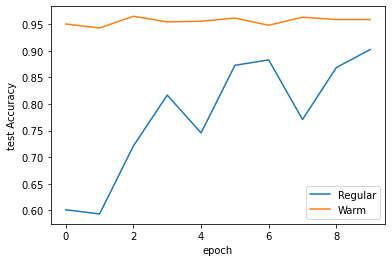

In [24]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')
sns.lineplot(x='epoch', y='test Accuracy', data=warmstart_results, label='Warm')

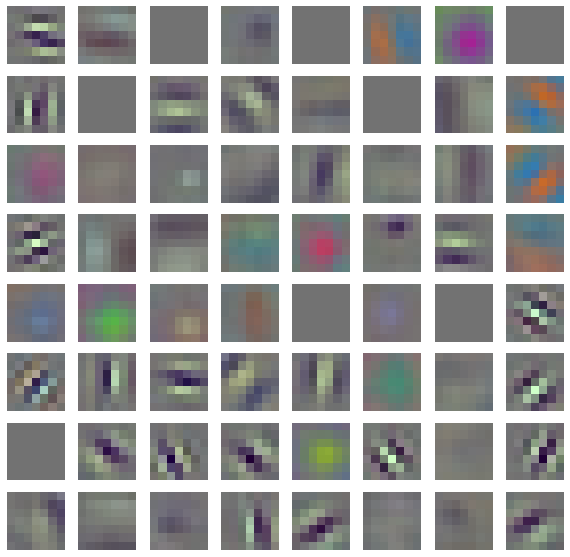

In [25]:
filters_catdog_finetuned = model_pretrained.baseModel.conv1.weight.data.cpu().numpy() #grab the filters after fine-tuning the warm started model
visualizeFilters(filters_catdog_finetuned) #Plot the filters, which will look very similar to the pre-trained model's initial filters

In [26]:
model_frozen = torchvision.models.resnet18(pretrained=True)
#First, turn off gradient updating for all parameters!
for param in model_frozen.parameters():
    param.requires_grad = False
#Our new FC layer has requires_grad = True by default!
model_frozen.fc = nn.Linear(model_frozen.fc.in_features, 2)
model_frozen = NormalizeInput(model_frozen)
frozen_transfer_results = train_network(model_frozen, loss, train_loader, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

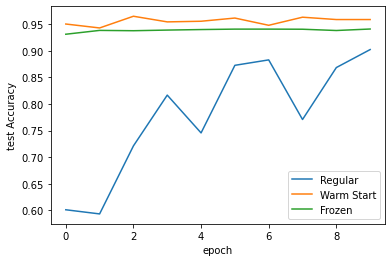

In [27]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_results, label='Regular')
sns.lineplot(x='epoch', y='test Accuracy', data=warmstart_results, label='Warm Start')
sns.lineplot(x='epoch', y='test Accuracy', data=frozen_transfer_results, label='Frozen')

In [28]:
train_data_small, _ = torch.utils.data.random_split(train_data, (B*2,len(train_data)-B*2)) #Make the small dataset = 2* the batch size
train_loader_small = DataLoader(train_data_small, batch_size=B, shuffle=True) #Make the loader for this tiny dataset

In [29]:
#1) Training from scratch
model = torchvision.models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 2)

normal_small_results = train_network(model, loss, train_loader_small, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

#2) Now lets train the warm model
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) #We are going to perfrom some "surgery"
model = NormalizeInput(model)

warmstart_small_results = train_network(model, loss, train_loader_small, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

#3) Training with frozen weights
model = torchvision.models.resnet18(pretrained=True)
#First, turn off gradient updating for all parameters!
for param in model.parameters():
    param.requires_grad = False 
#Ouew new FC layer has requires_grad = True by default!
model.fc = nn.Linear(model.fc.in_features, 2)

model = NormalizeInput(model)

frozen_transfer_small_results = train_network(model, loss, train_loader, epochs=10, device=device, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

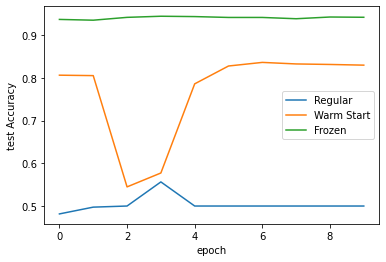

In [30]:
sns.lineplot(x='epoch', y='test Accuracy', data=normal_small_results, label='Regular')
sns.lineplot(x='epoch', y='test Accuracy', data=warmstart_small_results, label='Warm Start')
sns.lineplot(x='epoch', y='test Accuracy', data=frozen_transfer_small_results, label='Frozen')

In [31]:
# If you did not before, you'll need to install the `torchtext` and `sentencepiece` libraries. 
# pip install torchtext 
# pip install sentencepiece 

In [32]:
import torchtext
from torchtext.datasets import AG_NEWS

train_iter, test_iter = AG_NEWS(root='./data', split=('train', 'test'))
train_dataset_text = list(train_iter)
test_dataset_text = list(test_iter)

from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer

from collections import Counter #how many lines in this dataset
from torchtext.vocab import Vocab #we need to create a vocabulary of all the words in the training set

counter = Counter() 
for (label, line) in train_dataset_text: #loop through the training data 
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
vocab = Vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handls unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.

def label_transform(x): 
    return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3] 

VOCAB_SIZE = len(vocab)
NUN_CLASS = len(np.unique([z[0] for z in train_dataset_text]))
padding_idx = VOCAB_SIZE
VOCAB_SIZE += 1

In [33]:
# import torchtext
# from torchtext.datasets import text_classification

# train_dataset_text, test_dataset_text = text_classification.DATASETS['AG_NEWS'](root="./data/", ngrams=1, vocab=None)

In [34]:
train_data_text_small, _ = torch.utils.data.random_split(train_dataset_text, (256,len(train_dataset_text)-256)) #Slice off a tiny dataset

In [35]:
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch. 
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch]
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch]
    
    max_len = max([text.size(0) for text in texts])
    
    PAD = padding_idx
    
    texts = [F.pad(text, (0,max_len-text.size(0)), value=PAD) for text in texts]
    
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
    
    return x, y

In [36]:
embed_dim = 128
gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim), #(B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUN_CLASS), #(B, D) -> (B, classes)
)

#Create train & test loader using this collate_fn
train_text_loader = DataLoader(train_data_text_small, batch_size=32, shuffle=True, collate_fn=pad_batch)
test_text_loader = DataLoader(test_dataset_text, batch_size=32, collate_fn=pad_batch)
#Train our baseline GRU model
gru_results = train_network(gru, nn.CrossEntropyLoss(), train_text_loader, test_loader=test_text_loader, device=device, epochs=10, score_funcs={'Accuracy': accuracy_score})

In [37]:
# pip install transformers

In [38]:
from transformers import DistilBertTokenizer, DistilBertModel #Load the DistilBert classes
#initialize the tokenizer (converts strings-> input tensors) and the model (input tensorts -> output tensors)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [39]:
def huggingface_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch. 
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #these first three lines are the same as before
    texts = [z[1] for z in batch] #CHANGED: Don't use our old text_transform, just get the raw texts
    
    #New: Let huggingface encode a batch of strhings for us
    texts = tokenizer.batch_encode_plus(texts, return_tensors='pt', padding=True)['input_ids']
    
    #Now back to old code, stack them up and return the tensors
    x, y = texts, torch.tensor(labels, dtype=torch.int64)
    return x, y
#This is normal too, just making our data loaders with this new collage_fn
train_text_bert_loader = DataLoader(train_data_text_small, batch_size=32, shuffle=True, collate_fn=huggingface_batch)
test_text_bert_loader = DataLoader(test_dataset_text, batch_size=32, collate_fn=huggingface_batch)

In [40]:
class BertBasedClassifier(nn.Module): #our new class for frozen training of BERT models

    def __init__(self, bert_model, classes):
        """
        bert_model: the BERT based classification model to use as a forzen initial layer of the network
        classes: the number of output neurons / target classes for this classifier. 
        """
        super(BertBasedClassifier, self).__init__()
        self.bert_model = bert_model #We will get a tensort of (B, T, D) shape out from bert
        #So we will define a few of our own layers to get from (B, T, D) -> a prediction of shape (B, classes)
        self.attn = AttentionAvg(AdditiveAttentionScore(bert_model.config.dim)) #Attention to get down to (B, D) shape
        self.fc1 = nn.Linear(bert_model.config.dim, bert_model.config.dim)  #Do a little feature extraction
        self.pred = nn.Linear(bert_model.config.dim, classes) #Make a prediction about the class
        
    
    def forward(self, input):
        #Input is (B, T)
        mask = getMaskByFill(input)
        #This "with no_grad() does the freezing"
        with torch.no_grad():
            #huggingface returns a tuple, so unpack it!
            x = self.bert_model(input)[0] # (B, T, D)
        cntxt = x.sum(dim=1)/(mask.sum(dim=1).unsqueeze(1)+1e-5) #Compute the average embedding
        x = self.attn(x, cntxt, mask) #apply attention
        x = F.relu(self.fc1(x)) #Make preditions and return 
        return self.pred(x)
    
bertClassifier = BertBasedClassifier(bert_model, NUN_CLASS) #Build the classifier!
bert_results = train_network(bertClassifier, nn.CrossEntropyLoss(), train_text_bert_loader, test_loader=test_text_bert_loader, device=device, epochs=10, score_funcs={'Accuracy': accuracy_score})

<AxesSubplot:xlabel='epoch', ylabel='test Accuracy'>

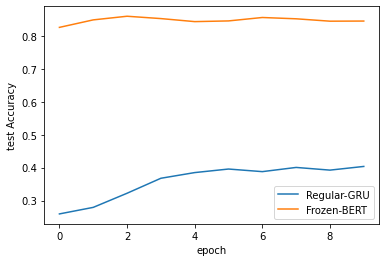

In [41]:
sns.lineplot(x='epoch', y='test Accuracy', data=gru_results, label='Regular-GRU')
sns.lineplot(x='epoch', y='test Accuracy', data=bert_results, label='Frozen-BERT')